In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Detect Hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Hardware Detected: {device}")
if torch.cuda.device_count() > 1:
    print(f"🚀 Multi-GPU Activated: {torch.cuda.device_count()} GPUs found!")

# Download NLTK resources silently
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
print("✅ Libraries Loaded Successfully.")

✅ Hardware Detected: cuda
🚀 Multi-GPU Activated: 2 GPUs found!
✅ Libraries Loaded Successfully.


In [8]:
# Path to dataset (Adjust if your path is different)
TRAIN_PATH = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"

# Check file existence
if not os.path.exists(TRAIN_PATH):
    print(f"❌ Error: File not found at {TRAIN_PATH}")
else:
    # Read text file with custom separator ':::'
    df = pd.read_csv(TRAIN_PATH, sep=':::', names=['ID', 'Title', 'Genre', 'Description'], engine='python')
    print(f"✅ Data Loaded. Shape: {df.shape}")
    print(df.head(3))

✅ Data Loaded. Shape: (54214, 4)
   ID                               Title       Genre  \
0   1       Oscar et la dame rose (2009)       drama    
1   2                       Cupid (1997)    thriller    
2   3   Young, Wild and Wonderful (1980)       adult    

                                         Description  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  


In [9]:
# 1. Clean whitespace from Genre column
df['Genre'] = df['Genre'].str.strip()

# 2. Check unique genres
unique_genres = df['Genre'].unique()
print(f"Found {len(unique_genres)} Unique Genres: \n{unique_genres}")

# 3. Drop rows with missing values (if any)
df.dropna(inplace=True)
print(f"Data Shape after cleanup: {df.shape}")

Found 27 Unique Genres: 
['drama' 'thriller' 'adult' 'documentary' 'comedy' 'crime' 'reality-tv'
 'horror' 'sport' 'animation' 'action' 'fantasy' 'short' 'sci-fi' 'music'
 'adventure' 'talk-show' 'western' 'family' 'mystery' 'history' 'news'
 'biography' 'romance' 'game-show' 'musical' 'war']
Data Shape after cleanup: (54214, 4)


/tmp/ipykernel_55/2780490609.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Genre', order=df['Genre'].value_counts().index, palette='viridis')


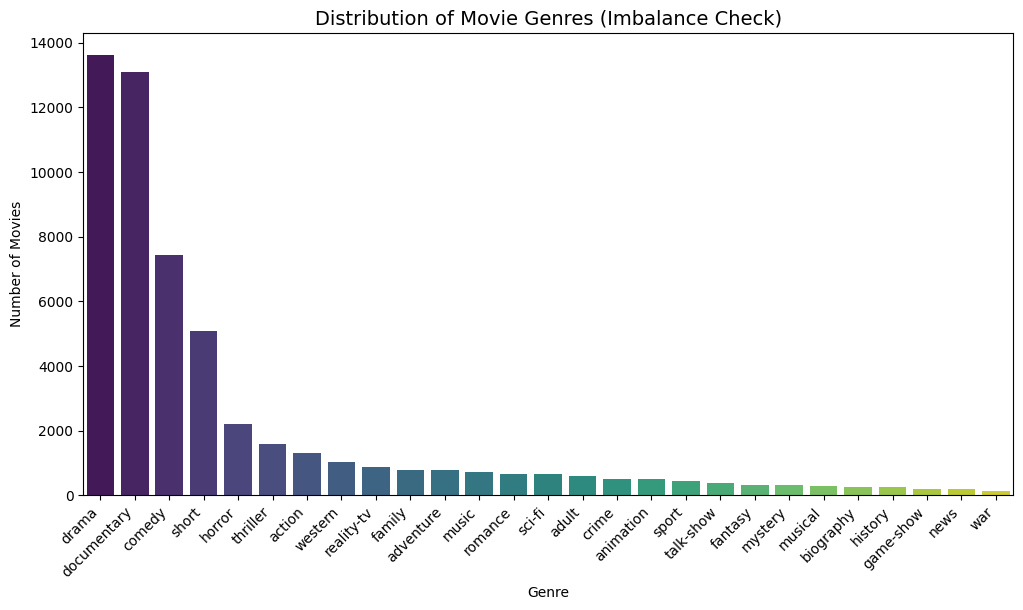

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Genre', order=df['Genre'].value_counts().index, palette='viridis')
plt.title("Distribution of Movie Genres (Imbalance Check)", fontsize=14)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha='right')
plt.show()

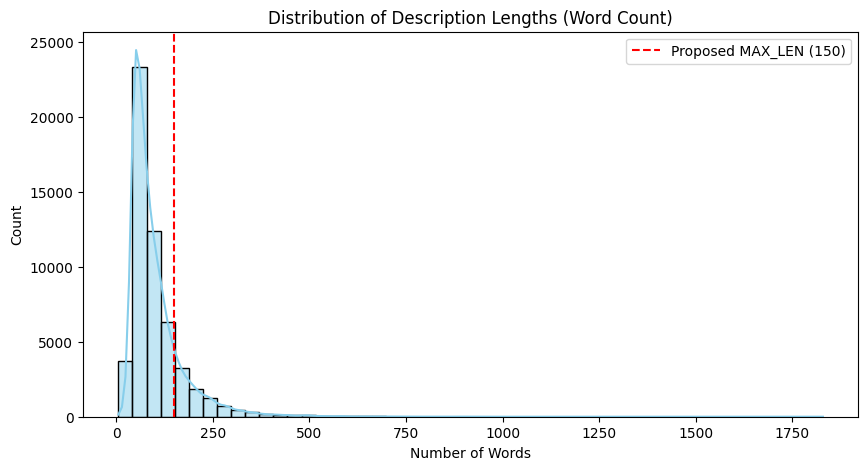

Average Length: 101.9 words


In [11]:
# Calculate length of each description (word count)
df['desc_len'] = df['Description'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['desc_len'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Description Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.axvline(x=150, color='red', linestyle='--', label='Proposed MAX_LEN (150)')
plt.legend()
plt.show()

print(f"Average Length: {df['desc_len'].mean():.1f} words")

/tmp/ipykernel_55/2945827103.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_words, x='Word', y='Count', palette='magma')


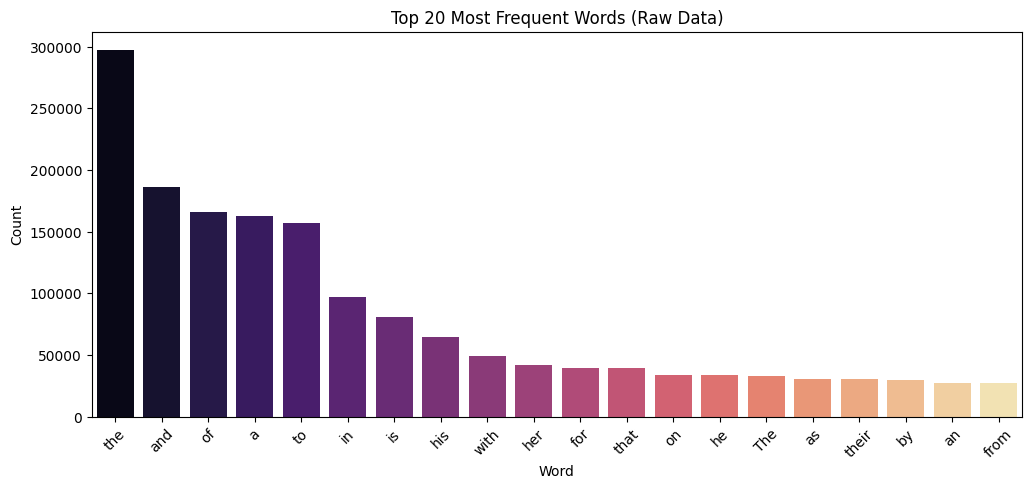

In [12]:
from collections import Counter

# Join all text and split into huge list of words
all_words = " ".join(df['Description'].values).split()
word_counts = Counter(all_words)

# Plot Top 20 Common Words
common_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 5))
sns.barplot(data=common_words, x='Word', y='Count', palette='magma')
plt.title("Top 20 Most Frequent Words (Raw Data)")
plt.xticks(rotation=45)
plt.show()

In [13]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text_pipeline(text):
    # 1. Lowercase & Remove HTML
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    
    # 2. Remove special chars/numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize
    words = text.split()
    
    # 4. Remove Stopwords & Stem
    # (Optional: Stemming can be aggressive, remove 'stemmer.stem(w)' if you prefer full words)
    cleaned = [stemmer.stem(w) for w in words if w not in stop_words]
    
    return " ".join(cleaned)

# Test it
sample = "<div>The <b>MOVIE</b> was thrilling 100%!!!</div>"
print(f"Original: {sample}")
print(f"Cleaned : {clean_text_pipeline(sample)}")

Original: <div>The <b>MOVIE</b> was thrilling 100%!!!</div>
Cleaned : movi thrill


In [14]:
print("⏳ Cleaning 54k descriptions... This may take a moment.")
# Using vectorization is faster than .apply()
clean_vectorized = np.vectorize(clean_text_pipeline)
df['clean_desc'] = clean_vectorized(df['Description'].values)

print("✅ Text Cleaning Complete!")
print(df[['Description', 'clean_desc']].head(2))

⏳ Cleaning 54k descriptions... This may take a moment.
✅ Text Cleaning Complete!
                                         Description  \
0   Listening in to a conversation between his do...   
1   A brother and sister with a past incestuous r...   

                                          clean_desc  
0  listen convers doctor parent yearold oscar lea...  
1  brother sister past incestu relationship curre...  


In [31]:
X = df['clean_desc'].values
y = df['Genre'].values

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Keeps genre ratio consistent
)

print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")

Training Samples: 43371
Validation Samples: 10843


In [15]:
# Download GloVe if missing
if not os.path.exists('glove.6B.zip'):
    print("Downloading GloVe...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

EMBED_DIM = 50

def load_glove(path):
    vocab = {'<pad>': 0, '<unk>': 1}
    vectors = [torch.zeros(EMBED_DIM), torch.randn(EMBED_DIM)]
    
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if len(parts) == EMBED_DIM + 1:
                vocab[word] = len(vectors)
                vectors.append(torch.tensor([float(x) for x in parts[1:]]))
                
    return vocab, torch.stack(vectors)

vocab_stoi, glove_matrix = load_glove("glove.6B.50d.txt")
print(f"✅ GloVe Loaded. Vocab Size: {len(vocab_stoi)}")

--2026-01-20 15:40:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-20 15:40:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-20 15:40:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [22]:
# Download GloVe if missing
if not os.path.exists('glove.6B.zip'):
    print("Downloading GloVe...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

EMBED_DIM = 50

def load_glove(path):
    vocab = {'<pad>': 0, '<unk>': 1}
    vectors = [torch.zeros(EMBED_DIM), torch.randn(EMBED_DIM)]
    
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if len(parts) == EMBED_DIM + 1:
                vocab[word] = len(vectors)
                vectors.append(torch.tensor([float(x) for x in parts[1:]]))
                
    return vocab, torch.stack(vectors)

vocab_stoi, glove_matrix = load_glove("glove.6B.50d.txt")
print(f"✅ GloVe Loaded. Vocab Size: {len(vocab_stoi)}")

✅ GloVe Loaded. Vocab Size: 400002


In [30]:
class MovieDataset(Dataset):
    def __init__(self, texts, labels, vocab, label2idx, max_len=150):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.label2idx = label2idx
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        # Text -> IDs
        words = str(self.texts[idx]).split()
        ids = [self.vocab.get(w, 1) for w in words]
        
        # Pad/Truncate
        if len(ids) < self.max_len:
            ids += [0] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
            
        # Label -> Int
        lbl = self.label2idx.get(self.labels[idx], 0)
        
        return torch.tensor(ids), torch.tensor(lbl)

In [32]:
# Label Mapping
GENRES = sorted(df['Genre'].unique())
label2idx = {g: i for i, g in enumerate(GENRES)}
idx2label = {i: g for i, g in enumerate(GENRES)}

# Datasets
train_ds = MovieDataset(X_train, y_train, vocab_stoi, label2idx)
val_ds = MovieDataset(X_val, y_val, vocab_stoi, label2idx)

# DataLoaders (Double batch size for Multi-GPU)
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Class Weights
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)
print("✅ DataLoaders Ready.")

✅ DataLoaders Ready.


In [33]:
class BiLSTMAttention(nn.Module):
    def __init__(self, embeddings, hidden_dim, output_dim, n_layers=2):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embeddings.shape[1], hidden_dim, num_layers=n_layers, 
                            bidirectional=True, batch_first=True, dropout=0.3)
        self.attn_fc = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def attention(self, lstm_out):
        energy = torch.tanh(self.attn_fc(lstm_out))
        weights = torch.softmax(energy, dim=1)
        context = torch.bmm(weights.permute(0, 2, 1), lstm_out).squeeze(1)
        return context

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        context = self.attention(lstm_out)
        return self.fc(self.dropout(context))

In [34]:
model = BiLSTMAttention(glove_matrix, hidden_dim=128, output_dim=len(GENRES))
model = model.to(device)

if torch.cuda.device_count() > 1:
    print("🚀 Wrapping model in DataParallel for Multi-GPU")
    model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

🚀 Wrapping model in DataParallel for Multi-GPU


In [35]:
EPOCHS = 10
train_losses, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for ids, labels in train_loader:
        ids, labels = ids.to(device), labels.to(device)
        
        optimizer.zero_grad()
        preds = model(ids)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

print("✅ Training Complete!")

Epoch 1 | Loss: 2.8084
Epoch 2 | Loss: 2.2820
Epoch 3 | Loss: 2.0220
Epoch 4 | Loss: 1.8348
Epoch 5 | Loss: 1.6602
Epoch 6 | Loss: 1.5016
Epoch 7 | Loss: 1.3396
Epoch 8 | Loss: 1.1883
Epoch 9 | Loss: 1.0311
Epoch 10 | Loss: 0.9141
✅ Training Complete!


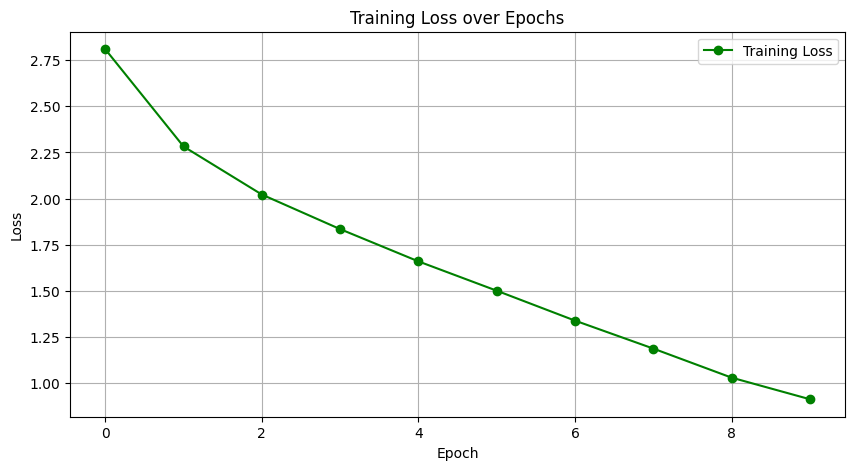

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, marker='o', color='green', label='Training Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def predict_genre(text):
    model.eval()
    cleaned = clean_text_pipeline(text)
    words = cleaned.split()
    ids = [vocab_stoi.get(w, 1) for w in words]
    
    # Pad to 150
    if len(ids) < 150: ids += [0]*(150-len(ids))
    else: ids = ids[:150]
    
    tensor_ids = torch.tensor(ids).unsqueeze(0).to(device)
    
    with torch.no_grad():
        preds = model(tensor_ids)
        probs = torch.softmax(preds, dim=1)
        pred_idx = torch.argmax(probs).item()
        
    return idx2label[pred_idx], probs[0][pred_idx].item()

# Test
genre, conf = predict_genre("A detective investigates a murder in a dark city.")
print(f"Predicted: {genre} ({conf*100:.1f}%)")





Predicted: mystery (20.4%)
